In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import scipy.spatial as scipy_spatial

In [2]:
from utils import plot_color_mesh
from utils import select_stars
import lsst.daf.persistence as daf_persistence
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from lsst.meas.algorithms import LoadIndexedReferenceObjectsConfig
import lsst.geom as lsst_geom

In [3]:
hsc_dir = '/project/danielsf/hsc_reprocessing/190930/single_visit'
assert os.path.isdir(hsc_dir)
hsc_butler = daf_persistence.Butler(hsc_dir)

In [4]:
ref_cat_name = 'ps1_pv3_3pi_20170110'

In [5]:
g_visits=[6320, 34338, 34342, 34362, 34366, 34382, 34384, 34400, 34402, 34412, 34414,
          34422, 34424, 34448, 34450, 34464, 34468, 34478, 34480, 34482, 34484, 34486]
r_visits=[7138, 34640, 34644, 34648, 34652, 34664, 34670, 34672, 34674, 34676, 34686,
          34688, 34690, 34698, 34706, 34708, 34712, 34714, 34734, 34758, 34760, 34772]
i_visits=[35870, 35890, 35892, 35906, 35936, 35950, 35974, 36114, 36118, 36140, 36144,
          36148, 36158, 36160, 36170, 36172, 36180, 36182, 36190, 36192, 36202, 36204,
          36212, 36214, 36216, 36218, 36234, 36236, 36238, 36240, 36258, 36260, 36262]
z_visits=[36404, 36408, 36412, 36416, 36424, 36426, 36428, 36430, 36432, 36434, 36438,
          36442, 36444, 36446, 36448, 36456, 36458, 36460, 36466, 36474, 36476, 36480,
          36488, 36490, 36492, 36494, 36498, 36504, 36506, 36508, 38938, 38944, 38950]
y_visits=[34874, 34942, 34944, 34946, 36726, 36730, 36738, 36750, 36754, 36756, 36758,
          36762, 36768, 36772, 36774, 36776, 36778, 36788, 36790, 36792, 36794, 36800,
          36802, 36808, 36810, 36812, 36818, 36820, 36828, 36830, 36834, 36836, 36838]

visit_dict = {}
visit_dict['g'] = g_visits
visit_dict['r'] = r_visits
visit_dict['i'] = i_visits
visit_dict['z'] = z_visits
visit_dict['y'] = y_visits

In [6]:
ccd_num_list = list(range(0,9))+list(range(10,104))

In [72]:
import time
coord_ra = []
coord_dec = []
g_flux = []
calib_phot_used = []
calib_phot_reserved = []
t_start = time.time()
ct=0
for visit_num in visit_dict['g']:
    for ccd_num in ccd_num_list:
        data_id = {'visit': visit_num, 'ccd':ccd_num}
        src = hsc_butler.get('src', dataId=data_id)
        calib = hsc_butler.get('calexp_photoCalib', dataId=data_id)
        valid = (src['calib_photometry_used'] | src['calib_photometry_reserved'])
        src = src[valid]
        g_flux_and_err = calib.instFluxToNanojansky(src, 'base_PsfFlux')
        coord_ra.append(src['coord_ra'])
        coord_dec.append(src['coord_dec'])
        g_flux.append(g_flux_and_err[:,0])
        calib_phot_used.append(src['calib_photometry_used'])
        calib_phot_reserved.append(src['calib_photometry_reserved'])

    ct += 1
    duration = (time.time()-t_start)/3600.0
    per = duration/ct
    pred = per*len(visit_dict['g'])
    print(ct,duration,pred)

coord_ra = np.concatenate(coord_ra)
coord_dec = np.concatenate(coord_dec)
g_flux = np.concatenate(g_flux)
calib_phot_used = np.concatenate(calib_phot_used)
calib_phot_reserved = np.concatenate(calib_phot_reserved)

1 0.0032221743795606823 0.070887836350335
2 0.005837074518203735 0.06420781970024109
3 0.008067555824915569 0.05916207604938084
4 0.010303444729910956 0.05666894601451026
5 0.012511160969734193 0.05504910826683045
6 0.02039215173986223 0.07477122304616152
7 0.02753419664171007 0.08653604658823165
8 0.03474214249187046 0.09554089185264376
9 0.04181325501865811 0.1022101789344976
10 0.04848644024795956 0.10667016854551103
11 0.05553445842530992 0.11106891685061984
12 0.06272107793225182 0.114988642875795
13 0.06954772644572788 0.1176961524466164
14 0.07695605761475033 0.12093094768032193
15 0.08406825270917681 0.12330010397345932
16 0.09090103083186679 0.12498891739381685
17 0.09778482079505921 0.12654506220537076
18 0.10501265989409553 0.12834880653722788
19 0.11233876347541809 0.13007646297153674
20 0.11969169828626845 0.1316608681148953
21 0.12673568917645348 0.13277072199437984
22 0.1340418008963267 0.1340418008963267


In [73]:
print('used ',calib_phot_used.sum())
print('reserved ',calib_phot_reserved.sum())
print(len(coord_ra))

used  69725
reserved  17438
87153


In [74]:
ref_config = LoadIndexedReferenceObjectsConfig()
ref_config.ref_dataset_name = ref_cat_name
ref_task = LoadIndexedReferenceObjectsTask(hsc_butler, config=ref_config)

In [75]:
ra_mid = np.median(coord_ra)
dec_mid = np.median(coord_dec)
xyz_mid = np.array([np.cos(dec_mid)*np.cos(ra_mid), np.cos(dec_mid)*np.sin(ra_mid), np.sin(dec_mid)])
xyz = np.array([np.cos(coord_dec)*np.cos(coord_ra),
                np.cos(coord_dec)*np.sin(coord_ra),
                np.sin(coord_dec)])

dist = np.arccos(np.dot(xyz.transpose(), xyz_mid))
print(dist.max())
print(ra_mid, dec_mid)
print(xyz[1].min(),xyz[1].max())

0.040120179818363466
5.893352774894023 0.012878150321096675
-0.4138303090878554 -0.34553529688682527


In [76]:
ref_cat = ref_task.loadSkyCircle(lsst_geom.SpherePoint(ra_mid*lsst_geom.radians, dec_mid*lsst_geom.radians),
                                 lsst_geom.Angle(1.05*dist.max()*lsst_geom.radians),
                                 filterName='g')

In [77]:
cdec = np.cos(ref_cat.refCat['coord_dec'])
ref_cat_spatial_data = np.array([cdec*np.cos(ref_cat.refCat['coord_ra']),
                                 cdec*np.sin(ref_cat.refCat['coord_ra']),
                                 np.sin(ref_cat.refCat['coord_dec'])])
ref_cat_spatial_tree = scipy_spatial.cKDTree(ref_cat_spatial_data.transpose(), leafsize=16)

In [78]:
cdec = np.cos(coord_dec)
hsc_spatial_data = np.array([cdec*np.cos(coord_ra),
                             cdec*np.sin(coord_ra),
                             np.sin(coord_dec)]).transpose()

In [79]:
%%time
fit_dist, fit_dex = ref_cat_spatial_tree.query(hsc_spatial_data, k=2)

CPU times: user 119 ms, sys: 72 µs, total: 119 ms
Wall time: 133 ms


In [80]:
dex = np.argmax(fit_dist[:,0]/fit_dist[:,1])
print(fit_dist[dex])
dist_rat = fit_dist[:,0]/fit_dist[:,1]
print(np.median(dist_rat))
print(np.sum(dist_rat<0.5))

[1.56720480e-07 1.61012973e-07]
0.0025981618239821046
87132


In [81]:
print(len(fit_dex[:,0]))
print(len(np.unique(fit_dex[:,0])))

87153
35688


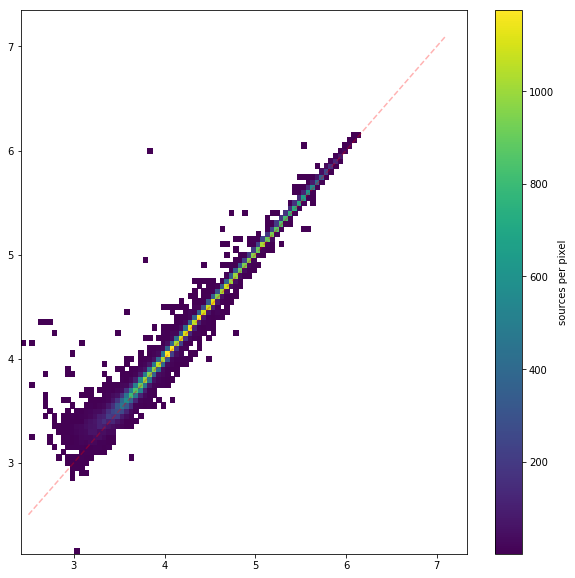

In [82]:
plt.figure(figsize=(10,10))
fit_dex_used = fit_dex[:,0][calib_phot_used]
plot_color_mesh(np.log10(g_flux[calib_phot_used]),
                np.log10(ref_cat.refCat['g_flux'][fit_dex_used]),
                0.05,0.05)
plt.plot([2.5,7.1], [2.5,7.1], linestyle='--', color='r', alpha=0.3)

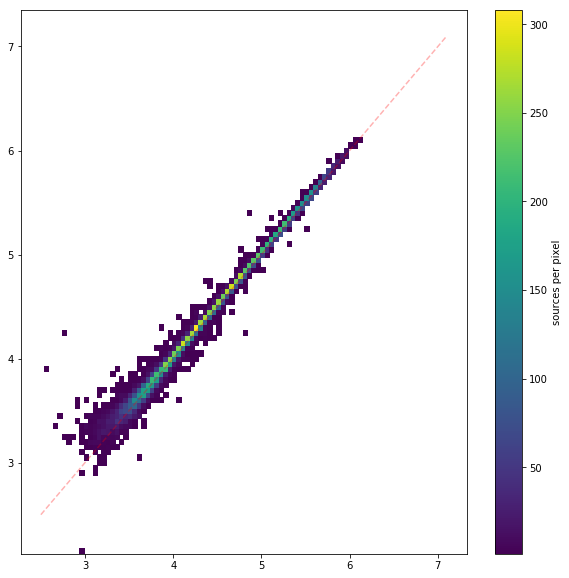

In [83]:
plt.figure(figsize=(10,10))
fit_dex_reserved = fit_dex[:,0][calib_phot_reserved]
plot_color_mesh(np.log10(g_flux[calib_phot_reserved]),
                np.log10(ref_cat.refCat['g_flux'][fit_dex_reserved]),
                0.05,0.05)
plt.plot([2.5,7.1], [2.5,7.1], linestyle='--', color='r', alpha=0.3)

In [36]:
print(ref_cat_spatial_data[1].min(),ref_cat_spatial_data[1].max())

-0.037813548073103415 0.04394311498154817


In [38]:
print(hsc_spatial_data[:,1].min(),hsc_spatial_data[:,1].max())

-0.4138303090878554 -0.3510377850512252


In [44]:
print(coord_ra.min(),coord_ra.max())
print(coord_dec.min(),coord_dec.max())

5.856525283231127 5.924492901108867
-0.019582414737115986 0.02522986385398839


In [45]:
print(ref_cat.refCat['coord_ra'].min(), ref_cat.refCat['coord_ra'].max())
print(ref_cat.refCat['coord_dec'].min(), ref_cat.refCat['coord_dec'].max())

5.846780794510347 5.9286246184170475
-0.03784968666042615 0.04399988187301415


In [ ]:
for line in src.schema:
    name = line[1].getName()
    if 'base_PsfFlux' in name:
        print(line)

In [ ]:
calib.instFluxToNanojansky(src, 'base_PsfFlux')


In [ ]:
dir(calib)